# DLBasics2023 最終課題
実行結果付き。
（手探りによる学習率 0.0003 で連続実行）
### 作者： tfujiwara
### 日付： 2023-Aug-02

## 課題
第11回「変分オートエンコーダ（VAE）を用いてFasionMNISTの画像を生成してみましょう」<br>
を発展させ、学習率探索プログラムを開発する

### 目標

課題の目標値は「NLL（負の対数尤度） 235」であったが、これにこだわらず、
自動探索により、良い検証結果の出る学習率が得られることとする。
以下の、オリジナル課題ルールは、あえて変更せず、**学習率とエポック数以外の条件を固定した中で、最良の検証結果を出す。**

### オリジナル課題ルール

- 訓練データは`x_train`，テストデータは`x_test`で与えられます．
- 下のセルで指定されている`x_train`以外の学習データは使わないでください．

### 評価方法

- 評価は生成画像の検証データに対するNLL（負の対数尤度）とした。<br>（オリジナル課題は、テストデータに対するNLL）

\begin{equation}
-\sum_{i=1}^Dx_i\log\hat{x_i}+(1-x_i)\log(1-\hat{x_i})
\end{equation}

### ドライブのマウント

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### データの読み込み（このセルは修正しないでください）

In [ ]:
import numpy as np
import pandas as pd
import torch

seed = 1234
torch.manual_seed(seed)
np.random.seed(seed)

# 学習データ
x_train = np.load('drive/MyDrive/Colab Notebooks/DLBasics2023_colab/FinalProj/data/x_train.npy')
# テストデータ
x_test = np.load('drive/MyDrive/Colab Notebooks/DLBasics2023_colab/FinalProj/data/x_test.npy')


class dataset(torch.utils.data.Dataset):
    def __init__(self, x_test):
        self.x_test = x_test.reshape(-1, 784).astype('float32') / 255

    def __len__(self):
        return self.x_test.shape[0]

    def __getitem__(self, idx):
        return torch.tensor(self.x_test[idx], dtype=torch.float)

trainval_data = dataset(x_train)
test_data = dataset(x_test)

### VAEの実装


In [ ]:
batch_size = 32

val_size = 10000
train_size = len(trainval_data) - val_size

train_data, val_data = torch.utils.data.random_split(trainval_data, [train_size, val_size])

dataloader_train = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True
)

dataloader_valid = torch.utils.data.DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=True
)

dataloader_test = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False
)

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from typing import Tuple

device = "cuda" if torch.cuda.is_available() else "cpu"


# torch.log(0)によるnanを防ぐ
def torch_log(x):
    return torch.log(torch.clamp(x, min=1e-10))

# VAEモデルの実装
class VAE(nn.Module):
    # WRITE ME
    def __init__(self, z_dim: int) -> None:
        super().__init__()

        # Encoder, xを入力にガウス分布のパラメータmu, sigmaを出力
        self.dense_enc1 = nn.Linear(28*28, 200)
        self.dense_enc2 = nn.Linear(200, 200)
        self.dense_encmean = nn.Linear(200, z_dim)
        self.dense_encvar = nn.Linear(200, z_dim)

        # Decoder, zを入力にベルヌーイ分布のパラメータlambdaを出力
        self.dense_dec1 = nn.Linear(z_dim, 200)
        self.dense_dec2 = nn.Linear(200, 200)
        self.dense_dec3 = nn.Linear(200, 28*28)

    def _encoder(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        x = F.relu(self.dense_enc1(x))
        x = F.relu(self.dense_enc2(x))
        mean = self.dense_encmean(x)
        std = F.softplus(self.dense_encvar(x))

        return mean, std

    def _sample_z(self, mean: torch.Tensor, std: torch.Tensor) -> torch.Tensor:
        if self.training:
            # 再パラメータ化トリック．この乱数は計算グラフで勾配の通り道に無い．
            epsilon = torch.randn(mean.shape).to(device)
            return mean + std * epsilon
        else:
            return mean

    def _decoder(self, z: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.dense_dec1(z))
        x = F.relu(self.dense_dec2(x))
        # 出力が0~1になるようにsigmoid
        x = torch.sigmoid(self.dense_dec3(x))

        return x

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        mean, std = self._encoder(x)
        z = self._sample_z(mean, std)
        x = self._decoder(z)
        return x, z

    def loss(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        mean, std = self._encoder(x)

        # KL loss(正則化項)の計算. mean, stdは (batch_size , z_dim)
        # torch.sumは上式のJ(=z_dim)に関するもの. torch.meanはbatch_sizeに関するものなので,
        # 上式には書いてありません.
        KL = -0.5 * torch.mean(torch.sum(1 + torch_log(std**2) - mean**2 - std**2, dim=1))

        z = self._sample_z(mean, std)
        y = self._decoder(z)

        # reconstruction loss(負の再構成誤差)の計算. x, yともに (batch_size , 784)
        # torch.sumは上式のD(=784)に関するもの. torch.meanはbatch_sizeに関するもの.
        reconstruction = torch.mean(torch.sum(x * torch_log(y) + (1 - x) * torch_log(1 - y), dim=1))

        return KL, -reconstruction

自分の関数の追加

In [ ]:

import datetime
import pytz
import math
timezone = 'Europe/Budapest'

def datetime_now():
    new_timezone = pytz.timezone(timezone)
    return datetime.datetime.now().astimezone(new_timezone)

class XPrint:
    ### 画面と同じものを記録する。
    def __init__(self, filename, mystr):
        self.filename = filename
        if ( mystr != "" ):
            self.message_time(mystr)
    def __call__(self, mystr):
        self.message("{} {}".format(datetime_now().strftime("%Y/%m/%d %H:%M:%S"), mystr))
    def message(self, mystr):
        try:
            with open(self.filename, "a") as f:
                f.write("{}\n".format(mystr))
        except FileNotFoundError:
            print("* "+mystr)
            return
        print("  "+mystr)
    def message_time(self, mystr):
        self.message("{} {}".format(datetime_now().strftime("%Y/%m/%d %H:%M:%S"), mystr))
xprint = XPrint('drive/MyDrive/Colab Notebooks/DLBasics2023_colab/FinalProj/xprint{}.txt'.format(datetime_now().strftime("%Y%m%d")), "")

  2023/07/28 07:18:08 EPOCH:1, Train Lower Bound:287.446960, (10.206648, 277.240326), Valid Lower Bound:256.454193  最小値更新
  2023/07/28 07:18:26 EPOCH:2, Train Lower Bound:255.131668, (11.316748, 243.814941), Valid Lower Bound:250.324661  最小値更新
  2023/07/28 07:18:43 EPOCH:3, Train Lower Bound:250.512146, (11.498050, 239.014084), Valid Lower Bound:246.438202  最小値更新
  2023/07/28 07:19:00 EPOCH:4, Train Lower Bound:248.279053, (11.659947, 236.619095), Valid Lower Bound:244.451706  最小値更新
  2023/07/28 07:19:17 EPOCH:5, Train Lower Bound:246.661789, (11.924916, 234.736877), Valid Lower Bound:242.606232  最小値更新
  2023/07/28 07:19:34 EPOCH:6, Train Lower Bound:245.517471, (12.091607, 233.425858), Valid Lower Bound:241.644516  最小値更新
  2023/07/28 07:19:52 EPOCH:7, Train Lower Bound:244.547729, (12.231719, 232.315979), Valid Lower Bound:241.209961  最小値更新
  2023/07/28 07:20:09 EPOCH:8, Train Lower Bound:243.799423, (12.340311, 231.459106), Valid Lower Bound:240.230438  最小値更新
  2023/07/28 07:20:26 EP

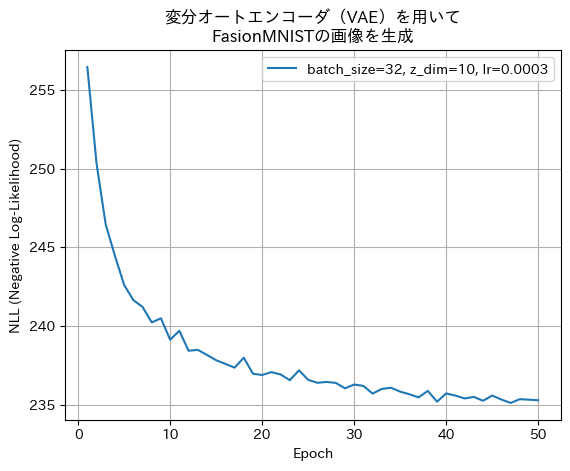

  2023/07/28 07:34:26 EPOCH:51, Train Lower Bound:237.705643, (13.150476, 224.555176), Valid Lower Bound:234.933838  最小値更新
  2023/07/28 07:34:50 EPOCH:52, Train Lower Bound:237.687424, (13.150457, 224.536957), Valid Lower Bound:235.214203  
  2023/07/28 07:35:13 EPOCH:53, Train Lower Bound:237.603745, (13.143476, 224.460281), Valid Lower Bound:235.017319  
  2023/07/28 07:35:36 EPOCH:54, Train Lower Bound:237.573975, (13.143675, 224.430298), Valid Lower Bound:235.288544  
  2023/07/28 07:35:59 EPOCH:55, Train Lower Bound:237.568619, (13.160501, 224.408127), Valid Lower Bound:234.771317  最小値更新
  2023/07/28 07:36:22 EPOCH:56, Train Lower Bound:237.523743, (13.144187, 224.379562), Valid Lower Bound:234.811676  
  2023/07/28 07:36:46 EPOCH:57, Train Lower Bound:237.486053, (13.141701, 224.344360), Valid Lower Bound:235.388626  
  2023/07/28 07:37:09 EPOCH:58, Train Lower Bound:237.473877, (13.159140, 224.314728), Valid Lower Bound:235.206818  
  2023/07/28 07:37:33 EPOCH:59, Train Lower Bo

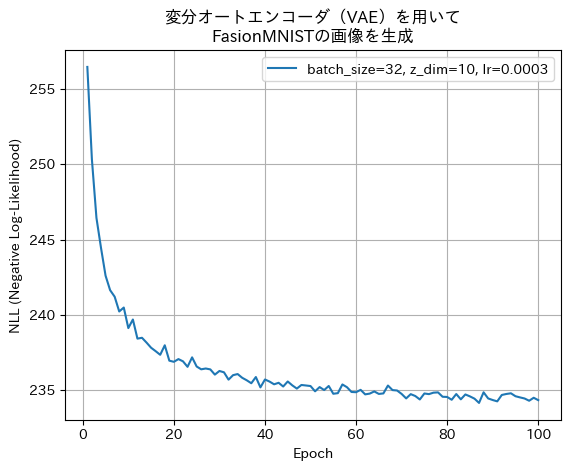

  2023/07/28 07:54:09 EPOCH:101, Train Lower Bound:236.601944, (13.269970, 223.331970), Valid Lower Bound:234.250275  
  2023/07/28 07:54:33 EPOCH:102, Train Lower Bound:236.576736, (13.277161, 223.299576), Valid Lower Bound:234.614822  
  2023/07/28 07:54:57 EPOCH:103, Train Lower Bound:236.561111, (13.269949, 223.291153), Valid Lower Bound:234.389450  
  2023/07/28 07:55:20 EPOCH:104, Train Lower Bound:236.544128, (13.271480, 223.272644), Valid Lower Bound:234.495834  
  2023/07/28 07:55:44 EPOCH:105, Train Lower Bound:236.549057, (13.287270, 223.261795), Valid Lower Bound:234.440613  
  2023/07/28 07:56:08 EPOCH:106, Train Lower Bound:236.527817, (13.274698, 223.253113), Valid Lower Bound:234.368668  
  2023/07/28 07:56:32 EPOCH:107, Train Lower Bound:236.487915, (13.260794, 223.227127), Valid Lower Bound:234.087204  最小値更新
  2023/07/28 07:56:57 EPOCH:108, Train Lower Bound:236.497101, (13.278571, 223.218536), Valid Lower Bound:234.274765  
  2023/07/28 07:57:20 EPOCH:109, Train Lowe

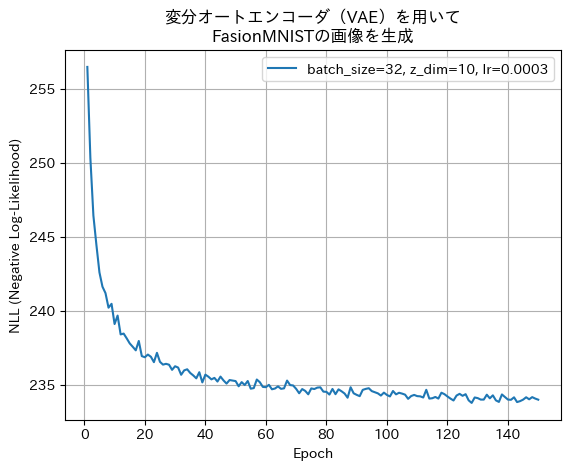

  2023/07/28 08:13:55 EPOCH:151, Train Lower Bound:236.066925, (13.328482, 222.738434), Valid Lower Bound:234.022415  
  2023/07/28 08:14:19 EPOCH:152, Train Lower Bound:236.039948, (13.301750, 222.738205), Valid Lower Bound:233.993454  
  2023/07/28 08:14:43 EPOCH:153, Train Lower Bound:236.056763, (13.320969, 222.735809), Valid Lower Bound:234.307709  
  2023/07/28 08:15:07 EPOCH:154, Train Lower Bound:236.045593, (13.331355, 222.714218), Valid Lower Bound:234.315094  
  2023/07/28 08:15:31 EPOCH:155, Train Lower Bound:236.026321, (13.320320, 222.705978), Valid Lower Bound:233.962189  
  2023/07/28 08:15:55 EPOCH:156, Train Lower Bound:236.064941, (13.354447, 222.710510), Valid Lower Bound:234.225159  
  2023/07/28 08:16:19 EPOCH:157, Train Lower Bound:236.029617, (13.328606, 222.701004), Valid Lower Bound:234.071838  
  2023/07/28 08:16:43 EPOCH:158, Train Lower Bound:236.031082, (13.332792, 222.698303), Valid Lower Bound:234.248306  
  2023/07/28 08:17:07 EPOCH:159, Train Lower Bou

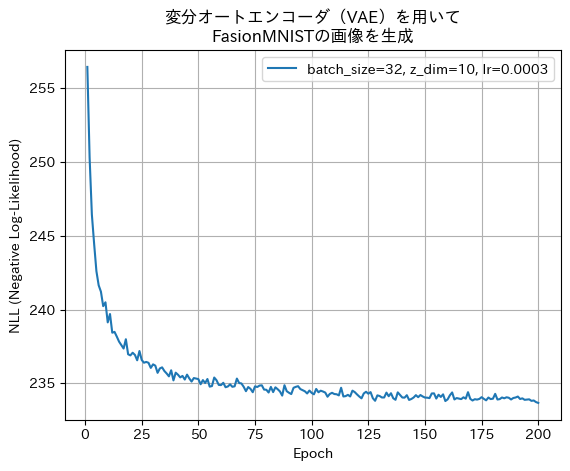

  2023/07/28 08:33:59 EPOCH:201, Train Lower Bound:235.767349, (13.357100, 222.410248), Valid Lower Bound:234.084488  
  2023/07/28 08:34:23 EPOCH:202, Train Lower Bound:235.750259, (13.355333, 222.394943), Valid Lower Bound:233.575134  最小値更新
  2023/07/28 08:34:47 EPOCH:203, Train Lower Bound:235.728455, (13.339527, 222.388931), Valid Lower Bound:233.658447  
  2023/07/28 08:35:11 EPOCH:204, Train Lower Bound:235.764755, (13.359018, 222.405746), Valid Lower Bound:233.863098  
  2023/07/28 08:35:35 EPOCH:205, Train Lower Bound:235.738525, (13.347074, 222.391449), Valid Lower Bound:233.837952  
  2023/07/28 08:36:00 EPOCH:206, Train Lower Bound:235.734772, (13.350768, 222.384003), Valid Lower Bound:233.714951  
  2023/07/28 08:36:23 EPOCH:207, Train Lower Bound:235.747299, (13.371161, 222.376129), Valid Lower Bound:233.987427  
  2023/07/28 08:36:48 EPOCH:208, Train Lower Bound:235.745972, (13.372754, 222.373199), Valid Lower Bound:234.132065  
  2023/07/28 08:37:12 EPOCH:209, Train Lowe

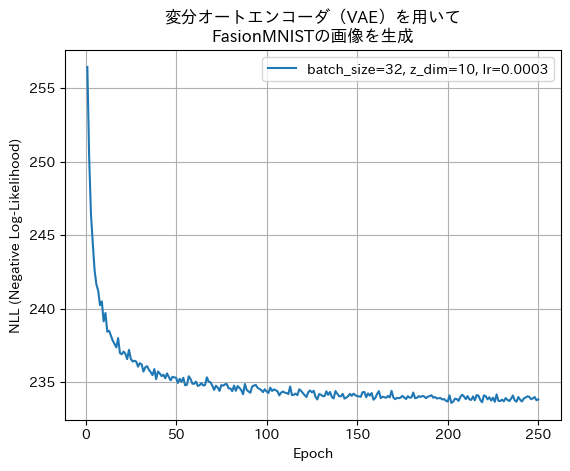

  2023/07/28 08:54:01 EPOCH:251, Train Lower Bound:235.571762, (13.385706, 222.186035), Valid Lower Bound:233.810455  
  2023/07/28 08:54:24 EPOCH:252, Train Lower Bound:235.530594, (13.354178, 222.176422), Valid Lower Bound:233.970154  
  2023/07/28 08:54:49 EPOCH:253, Train Lower Bound:235.566849, (13.394870, 222.171997), Valid Lower Bound:233.789383  
  2023/07/28 08:55:13 EPOCH:254, Train Lower Bound:235.552933, (13.383314, 222.169586), Valid Lower Bound:233.598297  
  2023/07/28 08:55:38 EPOCH:255, Train Lower Bound:235.546021, (13.378010, 222.168030), Valid Lower Bound:234.078430  
  2023/07/28 08:56:02 EPOCH:256, Train Lower Bound:235.517502, (13.366214, 222.151291), Valid Lower Bound:233.657471  
  2023/07/28 08:56:26 EPOCH:257, Train Lower Bound:235.506363, (13.363978, 222.142410), Valid Lower Bound:233.828430  
  2023/07/28 08:56:51 EPOCH:258, Train Lower Bound:235.543518, (13.392174, 222.151352), Valid Lower Bound:233.890076  
  2023/07/28 08:57:14 EPOCH:259, Train Lower Bou

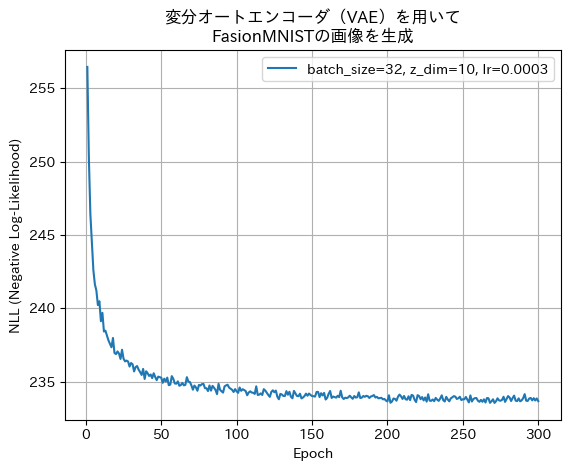

  2023/07/28 09:14:14 EPOCH:301, Train Lower Bound:235.388657, (13.399789, 221.988861), Valid Lower Bound:233.722443  
  2023/07/28 09:14:40 EPOCH:302, Train Lower Bound:235.399429, (13.393164, 222.006271), Valid Lower Bound:233.554306  最小値更新
  2023/07/28 09:15:05 EPOCH:303, Train Lower Bound:235.381958, (13.397899, 221.984055), Valid Lower Bound:233.745361  
  2023/07/28 09:15:29 EPOCH:304, Train Lower Bound:235.368332, (13.383737, 221.984589), Valid Lower Bound:233.730225  
  2023/07/28 09:15:53 EPOCH:305, Train Lower Bound:235.390030, (13.405456, 221.984573), Valid Lower Bound:233.705673  
  2023/07/28 09:16:18 EPOCH:306, Train Lower Bound:235.373230, (13.393814, 221.979416), Valid Lower Bound:233.877716  
  2023/07/28 09:16:42 EPOCH:307, Train Lower Bound:235.397980, (13.409591, 221.988403), Valid Lower Bound:233.756683  
  2023/07/28 09:17:07 EPOCH:308, Train Lower Bound:235.406189, (13.418542, 221.987640), Valid Lower Bound:233.829453  
  2023/07/28 09:17:31 EPOCH:309, Train Lowe

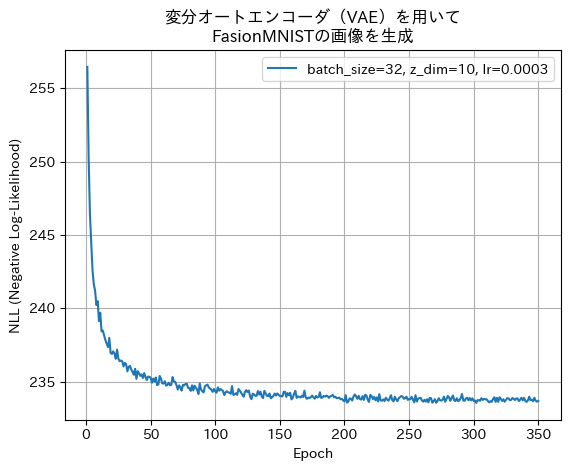

  2023/07/28 09:34:17 EPOCH:351, Train Lower Bound:235.263107, (13.409216, 221.853882), Valid Lower Bound:233.712112  
  2023/07/28 09:34:41 EPOCH:352, Train Lower Bound:235.253845, (13.398510, 221.855362), Valid Lower Bound:234.032196  
  2023/07/28 09:35:05 EPOCH:353, Train Lower Bound:235.266373, (13.399629, 221.866730), Valid Lower Bound:233.683060  
  2023/07/28 09:35:29 EPOCH:354, Train Lower Bound:235.236969, (13.395044, 221.841919), Valid Lower Bound:233.807129  
  2023/07/28 09:35:54 EPOCH:355, Train Lower Bound:235.281921, (13.419970, 221.861923), Valid Lower Bound:233.673019  
  2023/07/28 09:36:17 EPOCH:356, Train Lower Bound:235.266876, (13.403262, 221.863586), Valid Lower Bound:233.747711  
  2023/07/28 09:36:41 EPOCH:357, Train Lower Bound:235.263901, (13.422697, 221.841217), Valid Lower Bound:233.607956  
  2023/07/28 09:37:05 EPOCH:358, Train Lower Bound:235.267639, (13.415889, 221.851761), Valid Lower Bound:233.731659  
  2023/07/28 09:37:28 EPOCH:359, Train Lower Bou

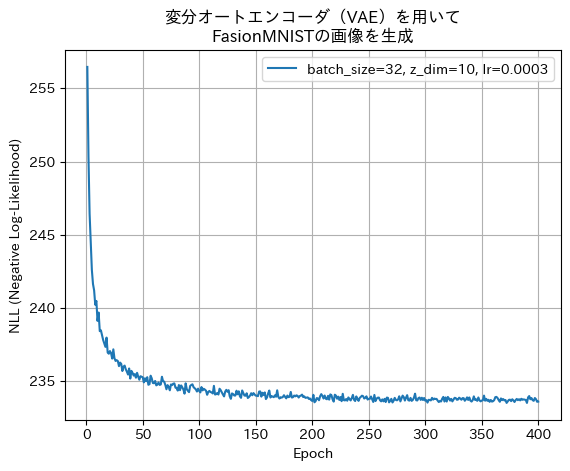

  2023/07/28 09:53:58 EPOCH:401, Train Lower Bound:235.165726, (13.432085, 221.733627), Valid Lower Bound:233.718246  
  2023/07/28 09:54:22 EPOCH:402, Train Lower Bound:235.161285, (13.431194, 221.730103), Valid Lower Bound:233.865646  
  2023/07/28 09:54:46 EPOCH:403, Train Lower Bound:235.125870, (13.414396, 221.711487), Valid Lower Bound:233.473648  最小値更新
  2023/07/28 09:55:09 EPOCH:404, Train Lower Bound:235.145477, (13.413498, 221.731995), Valid Lower Bound:233.710312  
  2023/07/28 09:55:33 EPOCH:405, Train Lower Bound:235.142960, (13.419542, 221.723419), Valid Lower Bound:233.779877  
  2023/07/28 09:55:57 EPOCH:406, Train Lower Bound:235.150528, (13.424410, 221.726120), Valid Lower Bound:233.789841  
  2023/07/28 09:56:20 EPOCH:407, Train Lower Bound:235.136475, (13.438868, 221.697601), Valid Lower Bound:233.646011  
  2023/07/28 09:56:45 EPOCH:408, Train Lower Bound:235.174866, (13.432075, 221.742798), Valid Lower Bound:234.131989  
  2023/07/28 09:57:08 EPOCH:409, Train Lowe

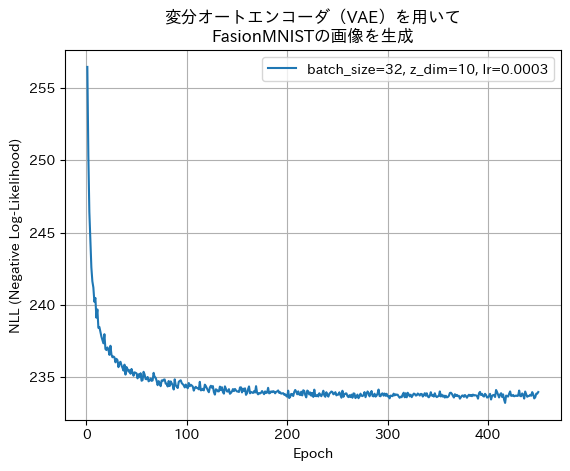

  2023/07/28 10:13:43 EPOCH:451, Train Lower Bound:235.089325, (13.436183, 221.653152), Valid Lower Bound:233.752502  
  2023/07/28 10:14:06 EPOCH:452, Train Lower Bound:235.058212, (13.428487, 221.629730), Valid Lower Bound:233.665588  
  2023/07/28 10:14:29 EPOCH:453, Train Lower Bound:235.084442, (13.442712, 221.641739), Valid Lower Bound:233.678421  
  2023/07/28 10:14:53 EPOCH:454, Train Lower Bound:235.051010, (13.432670, 221.618347), Valid Lower Bound:233.520370  
  2023/07/28 10:15:16 EPOCH:455, Train Lower Bound:235.120636, (13.456881, 221.663757), Valid Lower Bound:233.703918  
  2023/07/28 10:15:40 EPOCH:456, Train Lower Bound:235.052979, (13.417933, 221.635056), Valid Lower Bound:233.667831  
  2023/07/28 10:16:03 EPOCH:457, Train Lower Bound:235.081894, (13.433673, 221.648209), Valid Lower Bound:233.582916  
  2023/07/28 10:16:27 EPOCH:458, Train Lower Bound:235.056320, (13.441305, 221.615005), Valid Lower Bound:233.483673  
  2023/07/28 10:16:51 EPOCH:459, Train Lower Bou

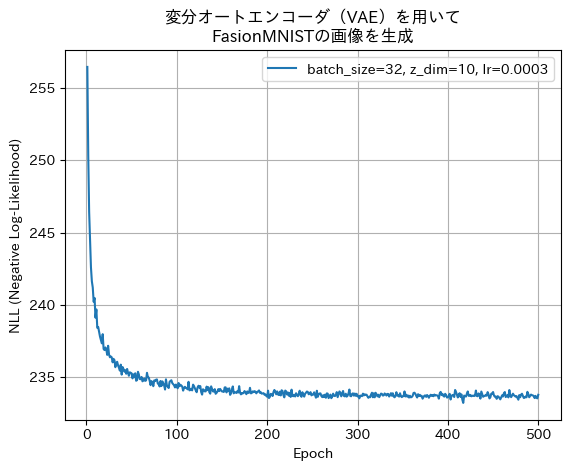

  2023/07/28 10:33:12 EPOCH:501, Train Lower Bound:234.981476, (13.441995, 221.539490), Valid Lower Bound:233.641144  
  2023/07/28 10:33:36 EPOCH:502, Train Lower Bound:235.007736, (13.458136, 221.549622), Valid Lower Bound:233.615372  
  2023/07/28 10:33:58 EPOCH:503, Train Lower Bound:234.987717, (13.453708, 221.533997), Valid Lower Bound:233.959457  
  2023/07/28 10:34:22 EPOCH:504, Train Lower Bound:235.002762, (13.448247, 221.554520), Valid Lower Bound:233.926468  
  2023/07/28 10:34:46 EPOCH:505, Train Lower Bound:235.002441, (13.453113, 221.549316), Valid Lower Bound:233.689392  
  2023/07/28 10:35:09 EPOCH:506, Train Lower Bound:234.997589, (13.454255, 221.543304), Valid Lower Bound:233.703018  
  2023/07/28 10:35:32 EPOCH:507, Train Lower Bound:235.003204, (13.458692, 221.544510), Valid Lower Bound:233.582413  
  2023/07/28 10:35:55 EPOCH:508, Train Lower Bound:235.013809, (13.451265, 221.562531), Valid Lower Bound:233.649643  
  2023/07/28 10:36:18 EPOCH:509, Train Lower Bou

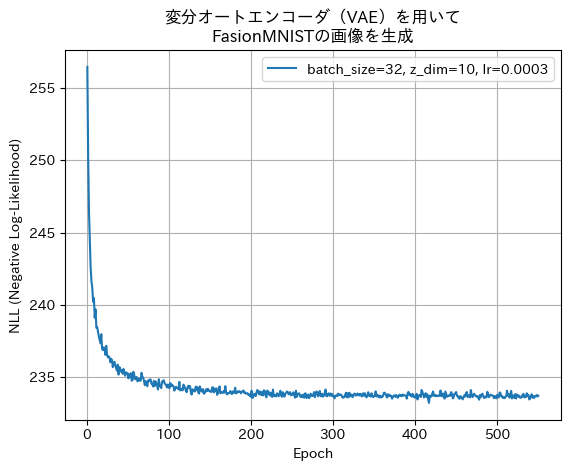

  2023/07/28 10:52:45 EPOCH:551, Train Lower Bound:234.954605, (13.463260, 221.491348), Valid Lower Bound:233.935257  
  2023/07/28 10:53:08 EPOCH:552, Train Lower Bound:234.936676, (13.461020, 221.475647), Valid Lower Bound:233.812897  
  2023/07/28 10:53:32 EPOCH:553, Train Lower Bound:234.935593, (13.458528, 221.477066), Valid Lower Bound:233.789368  
  2023/07/28 10:53:56 EPOCH:554, Train Lower Bound:234.915756, (13.453408, 221.462341), Valid Lower Bound:233.527008  
  2023/07/28 10:54:19 EPOCH:555, Train Lower Bound:234.937729, (13.450164, 221.487564), Valid Lower Bound:233.681213  
  2023/07/28 10:54:43 EPOCH:556, Train Lower Bound:234.939133, (13.459148, 221.479996), Valid Lower Bound:233.787247  
  2023/07/28 10:55:07 EPOCH:557, Train Lower Bound:234.964111, (13.475002, 221.489105), Valid Lower Bound:233.688950  
  2023/07/28 10:55:29 EPOCH:558, Train Lower Bound:234.956848, (13.471035, 221.485794), Valid Lower Bound:233.805756  
  2023/07/28 10:55:53 EPOCH:559, Train Lower Bou

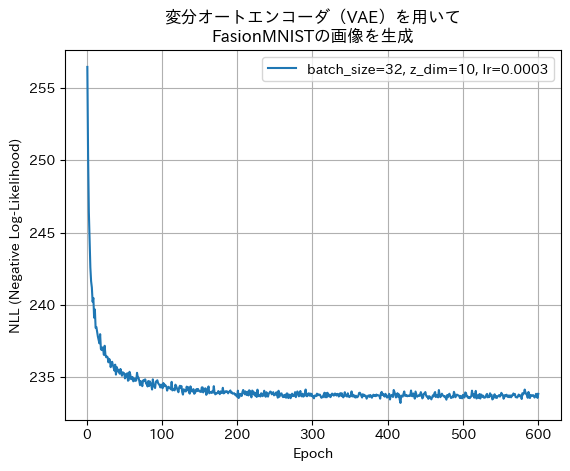

  2023/07/28 11:12:31 EPOCH:601, Train Lower Bound:234.879501, (13.474303, 221.405197), Valid Lower Bound:233.559036  
  2023/07/28 11:12:54 EPOCH:602, Train Lower Bound:234.892670, (13.482666, 221.410019), Valid Lower Bound:233.743866  
  2023/07/28 11:13:18 EPOCH:603, Train Lower Bound:234.880020, (13.472427, 221.407608), Valid Lower Bound:234.132660  
  2023/07/28 11:13:41 EPOCH:604, Train Lower Bound:234.868835, (13.460514, 221.408325), Valid Lower Bound:233.711441  
  2023/07/28 11:14:05 EPOCH:605, Train Lower Bound:234.898712, (13.469246, 221.429459), Valid Lower Bound:233.760239  
  2023/07/28 11:14:27 EPOCH:606, Train Lower Bound:234.885605, (13.480767, 221.404831), Valid Lower Bound:233.697830  
  2023/07/28 11:14:51 EPOCH:607, Train Lower Bound:234.860764, (13.460781, 221.399979), Valid Lower Bound:233.692596  
  2023/07/28 11:15:15 EPOCH:608, Train Lower Bound:234.903427, (13.492177, 221.411255), Valid Lower Bound:233.509766  
  2023/07/28 11:15:38 EPOCH:609, Train Lower Bou

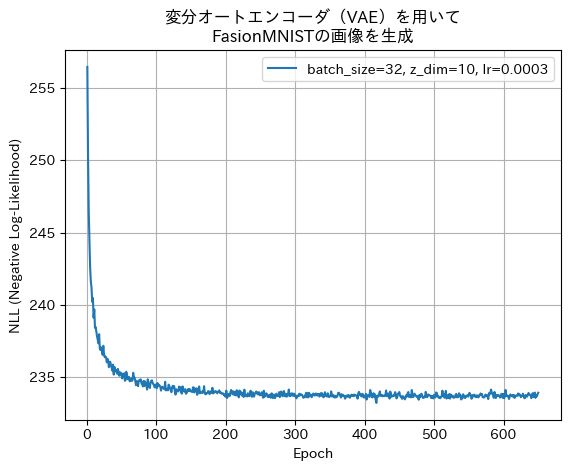

  2023/07/28 11:32:05 EPOCH:651, Train Lower Bound:234.856186, (13.475286, 221.380905), Valid Lower Bound:233.910538  
  2023/07/28 11:32:27 EPOCH:652, Train Lower Bound:234.845840, (13.482968, 221.362854), Valid Lower Bound:233.640503  
  2023/07/28 11:32:50 EPOCH:653, Train Lower Bound:234.866074, (13.480375, 221.385712), Valid Lower Bound:233.818970  
  2023/07/28 11:33:14 EPOCH:654, Train Lower Bound:234.827911, (13.488644, 221.339264), Valid Lower Bound:233.720230  
  2023/07/28 11:33:37 EPOCH:655, Train Lower Bound:234.828003, (13.469593, 221.358414), Valid Lower Bound:233.761139  
  2023/07/28 11:34:00 EPOCH:656, Train Lower Bound:234.866745, (13.500543, 221.366196), Valid Lower Bound:233.632141  
  2023/07/28 11:34:24 EPOCH:657, Train Lower Bound:234.838791, (13.488626, 221.350174), Valid Lower Bound:233.797577  
  2023/07/28 11:34:48 EPOCH:658, Train Lower Bound:234.835968, (13.489225, 221.346756), Valid Lower Bound:233.653824  
  2023/07/28 11:35:11 EPOCH:659, Train Lower Bou

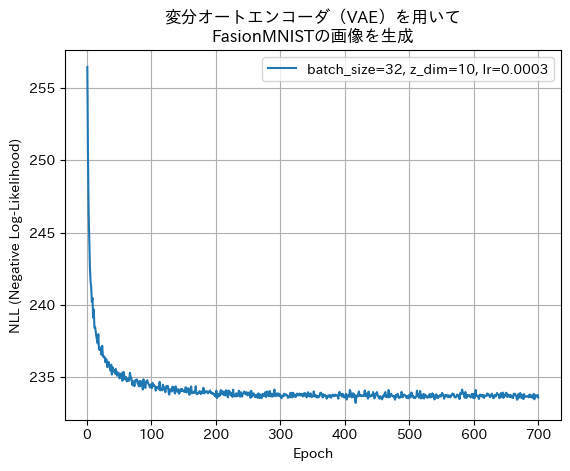

  2023/07/28 11:51:55 EPOCH:701, Train Lower Bound:234.800262, (13.489169, 221.311096), Valid Lower Bound:233.932510  
  2023/07/28 11:52:19 EPOCH:702, Train Lower Bound:234.802002, (13.489879, 221.312103), Valid Lower Bound:233.850906  
  2023/07/28 11:52:43 EPOCH:703, Train Lower Bound:234.799591, (13.488480, 221.311096), Valid Lower Bound:233.744064  
  2023/07/28 11:53:07 EPOCH:704, Train Lower Bound:234.776016, (13.461702, 221.314316), Valid Lower Bound:233.484070  
  2023/07/28 11:53:30 EPOCH:705, Train Lower Bound:234.794128, (13.477955, 221.316147), Valid Lower Bound:233.649460  
  2023/07/28 11:53:55 EPOCH:706, Train Lower Bound:234.804169, (13.500164, 221.304031), Valid Lower Bound:233.697479  
  2023/07/28 11:54:19 EPOCH:707, Train Lower Bound:234.799103, (13.492856, 221.306259), Valid Lower Bound:233.713730  
  2023/07/28 11:54:42 EPOCH:708, Train Lower Bound:234.786453, (13.478456, 221.307983), Valid Lower Bound:233.601807  
  2023/07/28 11:55:06 EPOCH:709, Train Lower Bou

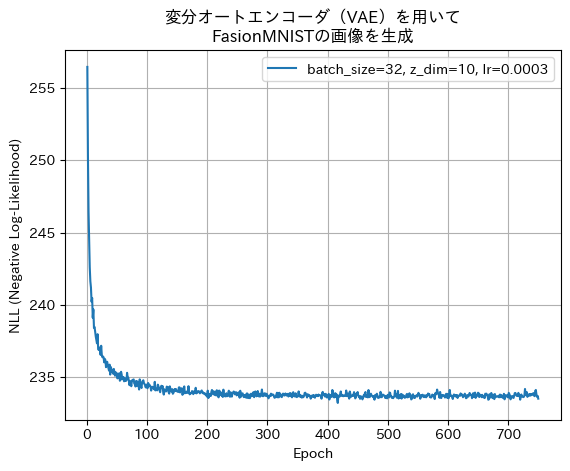

  2023/07/28 12:12:14 EPOCH:751, Train Lower Bound:234.735794, (13.471721, 221.264069), Valid Lower Bound:233.868210  
  2023/07/28 12:12:39 EPOCH:752, Train Lower Bound:234.776840, (13.509005, 221.267838), Valid Lower Bound:233.691162  
  2023/07/28 12:13:03 EPOCH:753, Train Lower Bound:234.766449, (13.479139, 221.287308), Valid Lower Bound:233.916702  
  2023/07/28 12:13:27 EPOCH:754, Train Lower Bound:234.768478, (13.495935, 221.272552), Valid Lower Bound:233.568344  
  2023/07/28 12:13:51 EPOCH:755, Train Lower Bound:234.741013, (13.483871, 221.257141), Valid Lower Bound:233.641830  
  2023/07/28 12:14:16 EPOCH:756, Train Lower Bound:234.820145, (13.494157, 221.325974), Valid Lower Bound:233.544998  
  2023/07/28 12:14:40 EPOCH:757, Train Lower Bound:234.747070, (13.489462, 221.257599), Valid Lower Bound:233.633011  
  2023/07/28 12:15:04 EPOCH:758, Train Lower Bound:234.774414, (13.510655, 221.263779), Valid Lower Bound:233.695740  
  2023/07/28 12:15:29 EPOCH:759, Train Lower Bou

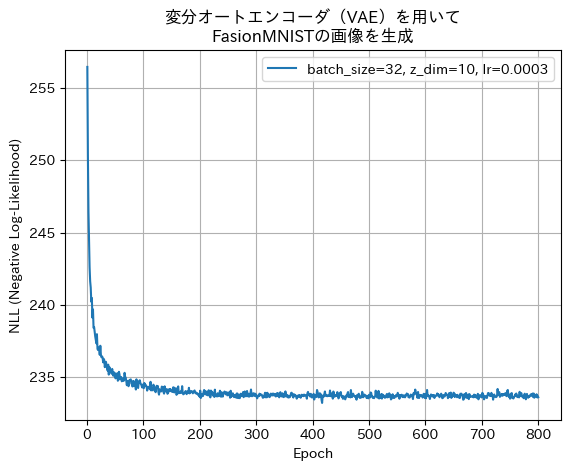

  2023/07/28 12:32:34 EPOCH:801, Train Lower Bound:234.754105, (13.523833, 221.230255), Valid Lower Bound:233.708237  
  2023/07/28 12:32:58 EPOCH:802, Train Lower Bound:234.743301, (13.511900, 221.231384), Valid Lower Bound:233.715958  
  2023/07/28 12:33:22 EPOCH:803, Train Lower Bound:234.731216, (13.509523, 221.221695), Valid Lower Bound:233.700729  
  2023/07/28 12:33:47 EPOCH:804, Train Lower Bound:234.750824, (13.504703, 221.246094), Valid Lower Bound:233.820038  
  2023/07/28 12:34:11 EPOCH:805, Train Lower Bound:234.722046, (13.499450, 221.222580), Valid Lower Bound:233.721893  
  2023/07/28 12:34:36 EPOCH:806, Train Lower Bound:234.727295, (13.511091, 221.216217), Valid Lower Bound:233.835007  
  2023/07/28 12:34:59 EPOCH:807, Train Lower Bound:234.698532, (13.480813, 221.217712), Valid Lower Bound:233.914185  
  2023/07/28 12:35:24 EPOCH:808, Train Lower Bound:234.727158, (13.510573, 221.216583), Valid Lower Bound:233.662460  
  2023/07/28 12:35:48 EPOCH:809, Train Lower Bou

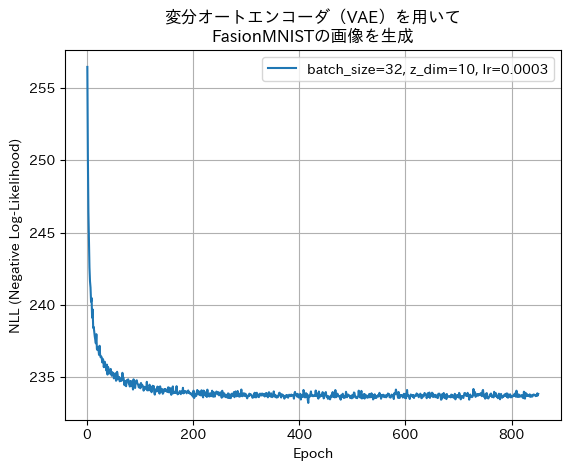

  2023/07/28 12:52:36 EPOCH:851, Train Lower Bound:234.656647, (13.502126, 221.154495), Valid Lower Bound:233.594696  
  2023/07/28 12:53:00 EPOCH:852, Train Lower Bound:234.706650, (13.509608, 221.197037), Valid Lower Bound:233.836594  
  2023/07/28 12:53:25 EPOCH:853, Train Lower Bound:234.673004, (13.504056, 221.168961), Valid Lower Bound:233.867844  
  2023/07/28 12:53:50 EPOCH:854, Train Lower Bound:234.684662, (13.513434, 221.171219), Valid Lower Bound:233.726089  
  2023/07/28 12:54:14 EPOCH:855, Train Lower Bound:234.686111, (13.509022, 221.177094), Valid Lower Bound:233.781876  
  2023/07/28 12:54:38 EPOCH:856, Train Lower Bound:234.686371, (13.507040, 221.179306), Valid Lower Bound:233.885986  
  2023/07/28 12:55:03 EPOCH:857, Train Lower Bound:234.672302, (13.505070, 221.167221), Valid Lower Bound:233.678619  
  2023/07/28 12:55:28 EPOCH:858, Train Lower Bound:234.683868, (13.488772, 221.195084), Valid Lower Bound:233.724487  
  2023/07/28 12:55:52 EPOCH:859, Train Lower Bou

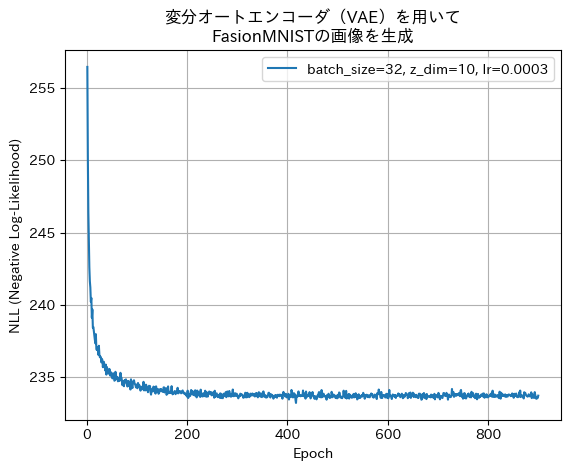

  2023/07/28 13:12:51 EPOCH:901, Train Lower Bound:234.682327, (13.508902, 221.173447), Valid Lower Bound:233.747284  
  2023/07/28 13:13:18 EPOCH:902, Train Lower Bound:234.683960, (13.530441, 221.153534), Valid Lower Bound:233.775314  
  2023/07/28 13:13:42 EPOCH:903, Train Lower Bound:234.661057, (13.508610, 221.152451), Valid Lower Bound:233.676025  
  2023/07/28 13:14:06 EPOCH:904, Train Lower Bound:234.679459, (13.511250, 221.168213), Valid Lower Bound:233.808685  
  2023/07/28 13:14:31 EPOCH:905, Train Lower Bound:234.642075, (13.511165, 221.130905), Valid Lower Bound:233.668686  
  2023/07/28 13:14:56 EPOCH:906, Train Lower Bound:234.685867, (13.536483, 221.149384), Valid Lower Bound:233.738373  
  2023/07/28 13:15:21 EPOCH:907, Train Lower Bound:234.651886, (13.510008, 221.141876), Valid Lower Bound:233.921829  
  2023/07/28 13:15:45 EPOCH:908, Train Lower Bound:234.642303, (13.512590, 221.129700), Valid Lower Bound:233.641724  
  2023/07/28 13:16:09 EPOCH:909, Train Lower Bou

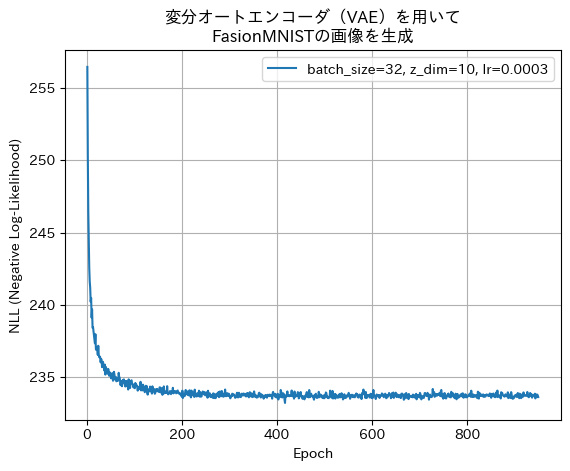

  2023/07/28 13:33:03 EPOCH:951, Train Lower Bound:234.637146, (13.524255, 221.112900), Valid Lower Bound:233.841705  
  2023/07/28 13:33:27 EPOCH:952, Train Lower Bound:234.628174, (13.504150, 221.123993), Valid Lower Bound:233.934784  
  2023/07/28 13:33:51 EPOCH:953, Train Lower Bound:234.661774, (13.526298, 221.135468), Valid Lower Bound:233.897461  
  2023/07/28 13:34:15 EPOCH:954, Train Lower Bound:234.621460, (13.510235, 221.111221), Valid Lower Bound:233.734756  
  2023/07/28 13:34:39 EPOCH:955, Train Lower Bound:234.641205, (13.519284, 221.121918), Valid Lower Bound:233.803360  
  2023/07/28 13:35:03 EPOCH:956, Train Lower Bound:234.651718, (13.520665, 221.131058), Valid Lower Bound:233.597946  
  2023/07/28 13:35:26 EPOCH:957, Train Lower Bound:234.620758, (13.519400, 221.101395), Valid Lower Bound:233.762802  
  2023/07/28 13:35:51 EPOCH:958, Train Lower Bound:234.627014, (13.522480, 221.104523), Valid Lower Bound:233.749649  
  2023/07/28 13:36:15 EPOCH:959, Train Lower Bou

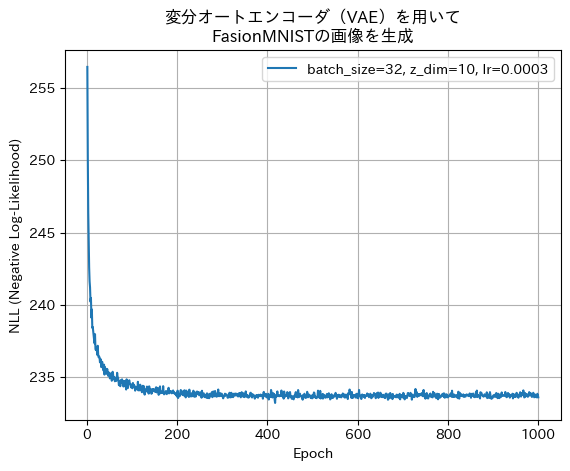

  2023/07/28 13:52:56 EPOCH:1001, Train Lower Bound:234.644882, (13.553541, 221.091354), Valid Lower Bound:233.811630  
  2023/07/28 13:53:20 EPOCH:1002, Train Lower Bound:234.621796, (13.530766, 221.091049), Valid Lower Bound:233.866409  
  2023/07/28 13:53:44 EPOCH:1003, Train Lower Bound:234.590317, (13.511039, 221.079269), Valid Lower Bound:233.695587  
  2023/07/28 13:54:07 EPOCH:1004, Train Lower Bound:234.632965, (13.534485, 221.098465), Valid Lower Bound:233.775085  
  2023/07/28 13:54:31 EPOCH:1005, Train Lower Bound:234.623703, (13.538312, 221.085373), Valid Lower Bound:233.915466  
  2023/07/28 13:54:56 EPOCH:1006, Train Lower Bound:234.620331, (13.528320, 221.092026), Valid Lower Bound:233.699677  


In [ ]:
#z_dim = 135 #10
z_dim = 10
assert z_dim >= 2
n_epochs = 1200 #15
lr=0.0003     #0.00151 #0.001
model = VAE(z_dim).to(device)
#optimizer = optim.Adam(model.parameters(), lr=lr) #0.001
optimizer = optim.Adam(model.parameters(), lr=lr) #0.001
!pip install japanize_matplotlib >nul
import matplotlib.pyplot as plt
import japanize_matplotlib
plt.clf()
gx = []
gy = []
title_font = {
    'color':  'black',
    'weight': 'bold',
    'size': 12,
}

min_valid_lower_bound = 9999                                                    # 最小値の初期値
for epoch in range(n_epochs):
    losses = []
    KL_losses = []
    reconstruction_losses = []
    model.train()
    for x in dataloader_train:

        # WRITE ME
        x = x.to(device)
        model.zero_grad()
        # KL_loss, reconstruction_lossの各項の計算
        KL_loss, reconstruction_loss = model.loss(x)
        # エビデンス下界の最大化のためマイナス付きの各項の値を最小化するようにパラメータを更新
        loss = KL_loss + reconstruction_loss
        loss.backward()
        optimizer.step()

        losses.append(loss.cpu().detach().numpy())
        KL_losses.append(KL_loss.cpu().detach().numpy())
        reconstruction_losses.append(reconstruction_loss.cpu().detach().numpy())

    losses_val = []
    model.eval()
    for x in dataloader_valid:

        # WRITE ME
        x = x.to(device)
        KL_loss, reconstruction_loss = model.loss(x)
        loss = KL_loss + reconstruction_loss

        losses_val.append(loss.cpu().detach().numpy())
    valid_lower_bound = np.average(losses_val)
    if valid_lower_bound < min_valid_lower_bound:
        min_valid_lower_bound = valid_lower_bound
        msg = "最小値更新"
    else:
        msg = ""
    xprint('EPOCH:%d, Train Lower Bound:%lf, (%lf, %lf), Valid Lower Bound:%lf  %s' %
          (epoch+1, np.average(losses), np.average(KL_losses), np.average(reconstruction_losses), np.average(losses_val), msg))
    gx.append(epoch+1)
    gy.append(np.average(losses_val))
    if (epoch+1) % 50 == 0:
        plt.plot(gx, gy, label=f'batch_size={batch_size}, z_dim={z_dim}, lr={lr}')
        plt.xlabel(f"Epoch")                                     # グラフ表示用
        plt.ylabel(f"NLL (Negative Log-Likelihood)")                             # グラフ表示用
        plt.grid(True)
        plt.legend()
        plt.title(f"変分オートエンコーダ（VAE）を用いて\nFasionMNISTの画像を生成", fontdict=title_font)
        plt.show()

In [ ]:
import csv

sample_x = []
answer = []
model.eval()
for x in dataloader_test:
    x = x.to(device)
    y, _ = model(x)
    y = y.tolist()
    sample_x.extend(y)

with open('drive/MyDrive/Colab Notebooks/DLBasics2023_colab/FinalProj/submission_pred.csv', 'w') as file:
    writer = csv.writer(file, lineterminator='\n')
    writer.writerows(sample_x)
file.close()